In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler
import time
import torch.nn as nn

In [2]:
torch.manual_seed(42)
np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 2
DATASET_CLUSTER_COUNT = 5
DATASET_R = 20

In [36]:
from cluster_tools import kmeans_elbow, ClusterSampler

Samplers

In [ ]:
from torch import nn

class LogisticModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1, bias=False)
        self.layer.weight.data.fill_(3)
    
    def forward(self, ai):
        x = self.layer(ai)
        res = torch.log(1 + torch.exp(x))
        return res.flatten()
    
    def forward(self, ai):
        x = self.layer(ai)
        res = torch.pow(x - 1, 2)/2
        return res.flatten()

def regress_criterion(output, batch):
    return output.mean()

In [6]:
from sklearn.datasets import make_blobs
clustered_data,_ = make_blobs(n_samples=DATASET_SIZE, 
                              n_features=DATASET_DIM,
                              centers=DATASET_CLUSTER_COUNT,
                              random_state=42)
clustered_data = clustered_data.astype(np.float32)

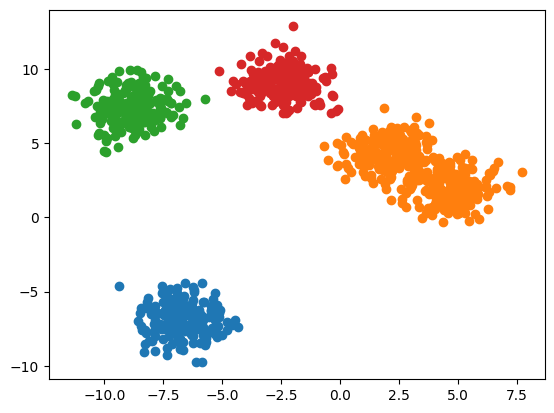

In [37]:
sampler = ClusterSampler(clustered_data, 64)
for i in range(sampler.cluster_count):
    selected = clustered_data[sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
plt.show()

Displaying what the clusters look like after evaluating the gradients

Solvers

In [ ]:
from solvers import solve_problem

In [9]:
from utils import clone_model

In [21]:
NB_EPOCH = 300
BATCH_SIZE = 64

In [22]:
base_model = LeastSquaresModel(clustered_data)

In [23]:
_, svrg_sol = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(clustered_data, shuffle=True),
                clustered_data,
                n_epoch=30)

100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


In [24]:
from torch.utils.data import SequentialSampler

_, cover_sol = COVER(clone_model(base_model, clustered_data),
                     regress_criterion,
                     clustered_data,
                     RandomSampler(clustered_data),
                     clustered_data,
                     n_epoch=30,
                     learning_rate=0.001)

100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


In [25]:
opt_val = calc_opt_least_square(clustered_data)

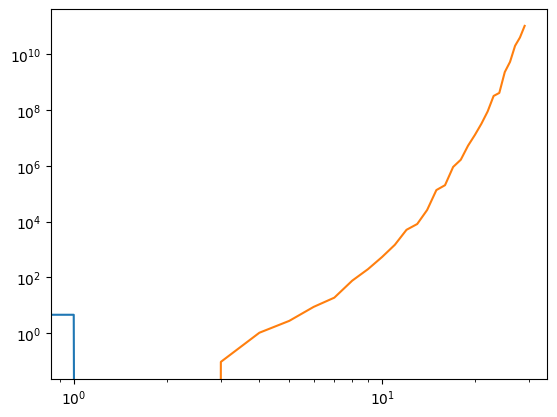

In [26]:
plt.plot(svrg_sol-opt_val)
plt.plot(cover_sol-opt_val)
plt.loglog()
plt.show()

In [27]:
from utils import clone_model

In [28]:
opt_model, sgd_sol = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=DataLoader(clustered_data, BATCH_SIZE, shuffle=True),
              epoch_count=NB_EPOCH,
              verbose=True)

Building models...


100%|██████████| 300/300 [00:03<00:00, 91.76it/s]


In [29]:
_, adam_sol = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=DataLoader(clustered_data, BATCH_SIZE, shuffle=True),
              epoch_count=NB_EPOCH,
              verbose=True)

Building models...


100%|██████████| 300/300 [00:03<00:00, 78.75it/s]


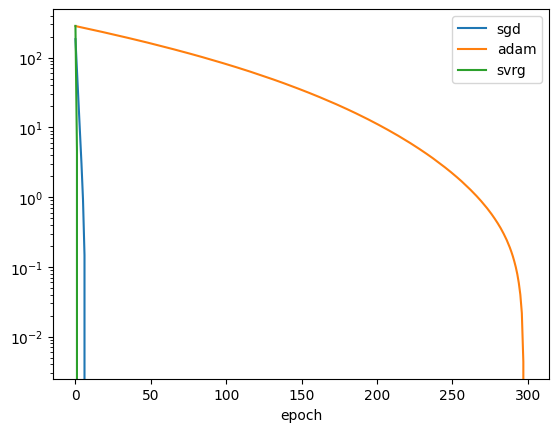

In [35]:
plt.plot(sgd_sol-opt_val, label="sgd")
plt.plot(adam_sol-opt_val, label="adam")
plt.plot(svrg_sol-opt_val, label="svrg")
plt.xlabel("epoch")
plt.legend()
plt.yscale("log")
plt.show()

In [33]:
iid_sampler = RandomSampler(clustered_data, replacement=True)
iid_dataloader = DataLoader(clustered_data, BATCH_SIZE, sampler=iid_sampler)

In [34]:
_, adam_sol_iid = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=iid_dataloader,
              epoch_count=NB_EPOCH,
              verbose=True)

Building models...


100%|██████████| 300/300 [00:03<00:00, 79.18it/s]


In [ ]:
cluster_sampler = ClusterSampler(clustered_data, BATCH_SIZE)
cluster_dataloader = DataLoader(clustered_data, BATCH_SIZE, sampler=iid_sampler)

In [ ]:
_, adam_sol_cluster = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=cluster_dataloader,
              epoch_count=NB_EPOCH,
              verbose=True)

Building models...


100%|██████████| 300/300 [00:03<00:00, 75.75it/s]


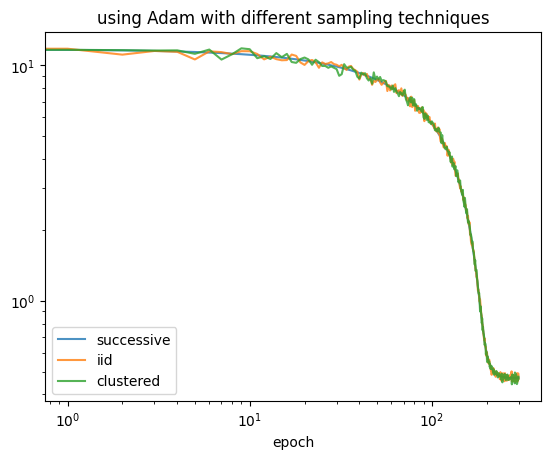

In [ ]:
plt.plot(adam_sol, label="successive", alpha=0.8)
plt.plot(adam_sol_iid, label="iid", alpha=0.8)
plt.plot(adam_sol_cluster, label="clustered", alpha=0.8)
plt.xlabel("epoch")
plt.legend()
plt.loglog()
plt.title("using Adam with different sampling techniques")
plt.show()

In [ ]:
_, sgd_sol_iid = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=iid_dataloader,
              epoch_count=NB_EPOCH,
              verbose=True)

_, sgd_sol_cluster = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=cluster_dataloader,
              epoch_count=NB_EPOCH,
              verbose=True)

Building models...


100%|██████████| 300/300 [00:03<00:00, 86.24it/s]


Building models...


100%|██████████| 300/300 [00:03<00:00, 80.43it/s]


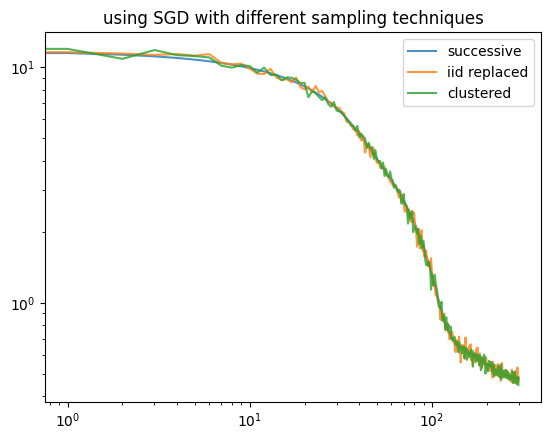

In [59]:
plt.plot(sgd_sol, label="successive", alpha=0.8)
plt.plot(sgd_sol_iid, label="iid replaced", alpha=0.8)
plt.plot(sgd_sol_cluster, label="clustered", alpha=0.8)
plt.legend()
plt.loglog()
plt.title("using SGD with different sampling techniques")
plt.show()

In [ ]:
def get_grad(batch, model):
    ret = np.zeros((len(batch), 2))
    for i, elem in enumerate(batch):
        res = model(elem)
        l = regress_criterion(res, "")
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

def display_grads(dataset, model, title=""):
    dataset_torch = torch.from_numpy(dataset)
    for i in range(sampler.cluster_count):
        selected = dataset_torch[sampler.clusters[i]]
        grad_selected = get_grad(selected, model)
        plt.scatter(grad_selected[:,0], grad_selected[:,1], alpha=0.5)

    plt.title(title)
    plt.show()

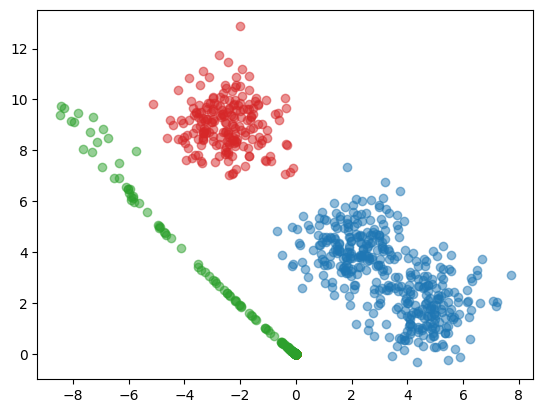

In [61]:
display_grads(clustered_data, base_model)

Building models...


100%|██████████| 80/80 [00:00<00:00, 91.48it/s]


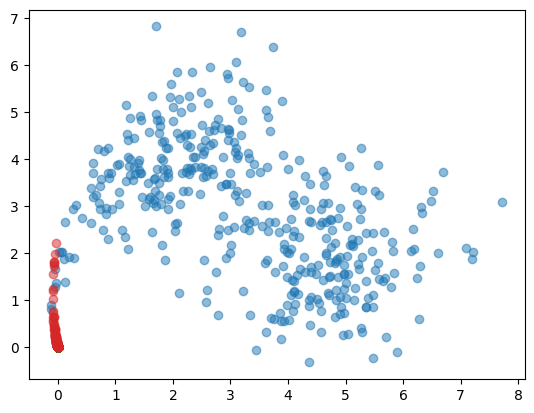

In [ ]:
model, _ = solve_problem(clone_model(base_model, clustered_data), 
                        regress_criterion,
                        optimizer_class=torch.optim.SGD,
                        dataloader=DataLoader(clustered_data, BATCH_SIZE, shuffle=True),
                        epoch_count=80,
                        verbose=True)
display_grads(clustered_data, model)

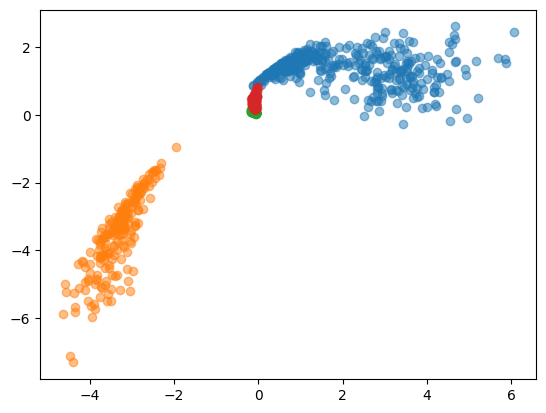

In [63]:
display_grads(clustered_data, opt_model)